In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the input data: convert to tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Configure the discriminator layers
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Configure the Generator layers
        self.model = nn.Sequential(
            nn.Linear(100, 7*7*256, bias=False),
            nn.BatchNorm1d(7*7*256),
            nn.LeakyReLU(0.3),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Initialize and assign models to the device
D = Discriminator().to(device)
G = Generator().to(device)

In [ ]:
# Initialize optimizers
optimizerD = optim.Adam(D.parameters(), lr=1e-4)
optimizerG = optim.Adam(G.parameters(), lr=1e-4)

criterion = nn.BCELoss()

def save_fake_images(epoch):
    os.makedirs('outputs', exist_ok=True)
    fixed_noise = torch.randn(32, 100, device=device)
    fake_images = G(fixed_noise).detach().cpu()
    save_image(fake_images, f'outputs/epoch_{epoch}.png', nrow=8, normalize=True)

# Training parameters
num_epochs = 50
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    d_loss_total = 0.0
    g_loss_total = 0.0
    for i, (images, _) in enumerate(train_loader):
        real_images = images.to(device)
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        D.zero_grad()
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        noise = torch.randn(images.size(0), 100, device=device)
        fake_images = G(noise)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizerD.step()
        d_loss_total += d_loss_real.item() + d_loss_fake.item()

        G.zero_grad()
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizerG.step()
        g_loss_total += g_loss.item()

    # Update losses
    d_losses.append(d_loss_total / len(train_loader))
    g_losses.append(g_loss_total / len(train_loader))

    # Record and print losses
    print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_losses[-1]:.4f}, g_loss: {g_losses[-1]:.4f}')

    if (epoch+1) in [10, 30, 50]:
        save_fake_images(epoch+1)

print('Training finished.')

Epoch [1/50], d_loss: 0.8180, g_loss: 1.9478
Epoch [2/50], d_loss: 1.0433, g_loss: 1.3261
Epoch [3/50], d_loss: 1.0567, g_loss: 1.3419
Epoch [4/50], d_loss: 1.1321, g_loss: 1.2224
Epoch [5/50], d_loss: 1.1955, g_loss: 1.1086
Epoch [6/50], d_loss: 1.2227, g_loss: 1.0255
Epoch [7/50], d_loss: 1.2438, g_loss: 0.9692
Epoch [8/50], d_loss: 1.2525, g_loss: 0.9453
Epoch [9/50], d_loss: 1.2470, g_loss: 0.9361
Epoch [10/50], d_loss: 1.2475, g_loss: 0.9306
Epoch [11/50], d_loss: 1.2351, g_loss: 0.9742
Epoch [12/50], d_loss: 1.2386, g_loss: 0.9465
Epoch [13/50], d_loss: 1.2383, g_loss: 0.9349
Epoch [14/50], d_loss: 1.2392, g_loss: 0.9542
Epoch [15/50], d_loss: 1.2364, g_loss: 0.9384
Epoch [16/50], d_loss: 1.2317, g_loss: 0.9575
Epoch [17/50], d_loss: 1.2310, g_loss: 0.9615
Epoch [18/50], d_loss: 1.2388, g_loss: 0.9421
Epoch [19/50], d_loss: 1.2395, g_loss: 0.9541
Epoch [20/50], d_loss: 1.2400, g_loss: 0.9516
Epoch [21/50], d_loss: 1.2415, g_loss: 0.9467
Epoch [22/50], d_loss: 1.2417, g_loss: 0.95

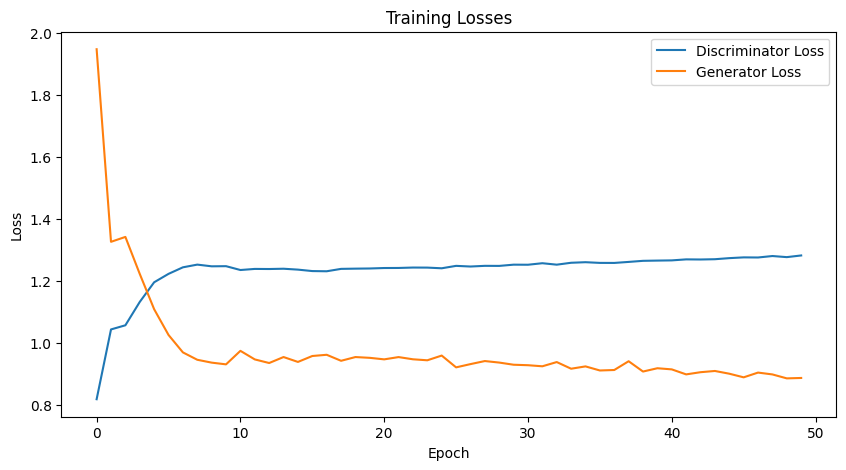

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

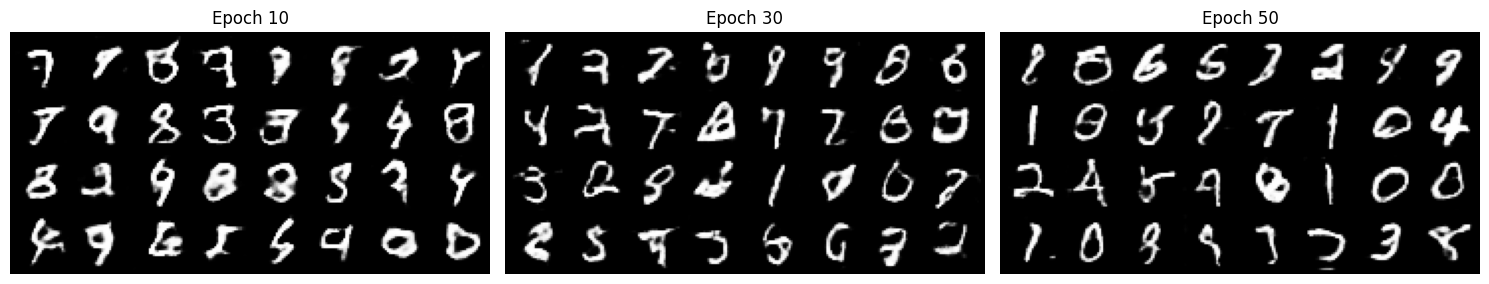

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob

def load_and_display_images_from_folder(folder_path='outputs', image_format='png'):
    if not os.path.exists(folder_path):
        print("Folder not found:", folder_path)
        return

    image_files = sorted(glob.glob(f'{folder_path}/*.{image_format}'), key=os.path.getmtime)

    num_images = len(image_files)
    if num_images == 0:
        print("No images found in the folder")
        return

    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()

    for ax, img_path in zip(axes, image_files):
        img = Image.open(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        epoch_number = os.path.basename(img_path).split('_')[1].split('.')[0]
        ax.set_title(f'Epoch {epoch_number}')

    for ax in axes[len(image_files):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

load_and_display_images_from_folder()